# Model Training & Evaluation Pipeline

Details: [Model Training Specifications](https://docs.google.com/document/d/1UiDi8nyTcfMeMNIAz3KntlVZBlYrpoMAURuDccTt-wk/edit?usp=sharing)

Model Evaluation: Identify best parameters for each model

In [1]:
# Basic Libraries

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data Source

df = pd.read_csv("/content/drive/MyDrive/cleaned_gee_data_v3.csv")
df = df.drop(columns = ['Unnamed: 0'], axis=1) # Drop index
df.head() 

,LATITUDE,LONGITUDE,CO_MOL/M2,SO2_MOL/M2,NO2_MOL/M2,O3_MOL/M2,FIRE_OCCURRED
0,0.079561,0.356387,0.252793,0.175102,0.048868,0.390066,0
1,0.079561,0.356387,0.267145,0.175102,0.048868,0.390066,0
2,0.079561,0.356387,0.252793,0.175102,0.041340,0.390066,0
3,0.079561,0.356387,0.267145,0.175102,0.041340,0.390066,0
4,0.083532,0.351189,0.154547,0.210118,0.045284,0.550787,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171893 entries, 0 to 171892
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   LATITUDE       171893 non-null  float64
 1   LONGITUDE      171893 non-null  float64
 2   CO_MOL/M2      171893 non-null  float64
 3   SO2_MOL/M2     171893 non-null  float64
 4   NO2_MOL/M2     171893 non-null  float64
 5   O3_MOL/M2      171893 non-null  float64
 6   FIRE_OCCURRED  171893 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 9.2 MB


In [4]:
display(df['FIRE_OCCURRED'].value_counts())

0    170544
1      1349
Name: FIRE_OCCURRED, dtype: int64

0.785% of FIRE_OCCURRED = 1

In [5]:
X = df.drop('FIRE_OCCURRED', axis=1)
y = df['FIRE_OCCURRED']

In [6]:
# Training, Validation, Testing Split

from sklearn.model_selection import train_test_split

# 80:10:10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=10, shuffle=True)

Original = [X_train, X_val, X_test, y_train, y_val, y_test] # For reference

In [7]:
if len(X_train)==len(y_train) and len(X_test) == len(y_test) and len(X_val) == len(y_val):
  print("X and y data length matching")
else:
  print("Error in data preparation pipeline")
print()
print("No. of training data = %d" % len(X_train))
print("No. of validation data = %d" % len(X_val))
print("No. of testing data = %d" % len(X_test))

X and y data length matching

No. of training data = 137513
No. of validation data = 17190
No. of testing data = 17190


In [8]:
display(y_val.value_counts())

0    17068
1      122
Name: FIRE_OCCURRED, dtype: int64

In [9]:
display(y_test.value_counts())

0    17059
1      131
Name: FIRE_OCCURRED, dtype: int64

In [10]:
# SMOTE

from collections import Counter
from imblearn.over_sampling import SMOTE 

print('Original dataset shape %s' % Counter(y_train))
sm = SMOTE(random_state=10)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 136417, 1: 1096})
Resampled dataset shape Counter({0: 136417, 1: 136417})


In [11]:
# Shuffle Data since SMOTE appended many 1s at the end
# Required for some algorithms such as ANN

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state = 10)

In [12]:
# Evaluation Metrics

from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score, accuracy_score

def evaluation_metrics(y_true, y_pred):
  cfm = confusion_matrix(y_true, y_pred).ravel()
  acc = accuracy_score(y_true, y_pred)
  recs = recall_score(y_true, y_pred, average='binary')
  f1s = f1_score(y_true, y_pred, average='binary')
  rocs = roc_auc_score(y_true, y_pred, average='macro')
  return [cfm, acc, recs, f1s, rocs]

Confusion matrix format : [ tn , fp , fn , tp ]

In [13]:
# Store Model Parameters and Eval

models = pd.DataFrame(columns = ['model_name', 'model', 'parameters'])
models_eval = pd.DataFrame(columns = ['model_name', 'confusion_matrix', 'accuracy', 'recall', 'f1_score', 'roc_auc_score'])

In [14]:
# Import ML Algorithms

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import VotingClassifier

# RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

## Logistic Regression

- Library: Scikit-learn

In [ ]:
# Training

name = 'log_clf'

train = pd.DataFrame(columns = ['penalty', 'warm_start', 'solver', 'max_iter', 'dual', 'n_jobs','random_state'])
train = train.append({'penalty' : 'none', 'warm_start': False, 'solver': 'newton-cg',  'max_iter': 247,  'dual': False, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'penalty' : 'l2', 'warm_start': False, 'solver': 'newton-cg',  'max_iter': 100,  'dual': False, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    log_clf = LogisticRegression(penalty = row['penalty'], n_jobs = int(row['n_jobs']), random_state = int(row['random_state']))
    log_clf.fit(X_train, y_train)
   
    y_true = y_val
    y_pred = log_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': log_clf, 
                            'parameters': log_clf.get_params()}, 
                            ignore_index=True)
   
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[10551, 6517, 38, 84]",0.618674,0.688525,0.024989,0.653349
1,log_clf1,"[10551, 6517, 39, 83]",0.618615,0.680328,0.024695,0.649251


In [ ]:
[np.arange(0, 1.1, 0.1)]

[array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])]

In [ ]:
# RandomizedSearchCV

random_grid = {
                "penalty": ['l1', 'l2', 'elasticnet', 'none'],
                "max_iter" :[100, 200, 300, 400, 500],
                "warm_start" : [True, False],
                "solver" : ['lbfgs', 'newton-cg', 'liblinear'],
                "C" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8, 1.0]
              }

log_random = RandomizedSearchCV(estimator = log_clf, 
                                param_distributions = random_grid, 
                                n_iter = 70, 
                                cv = 3, 
                                verbose = 3, 
                                scoring = 'recall',
                                random_state = 10)

log_random.fit(X_train, y_train)
log_random.best_params_

Fitting 3 folds for each of 70 candidates, totalling 210 fits
[CV 1/3] END C=0.2, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=0.2, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END C=0.2, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.8, max_iter=400, penalty=l1, solver=liblinear, warm_start=True;, score=0.659 total time=  13.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.8, max_iter=400, penalty=l1, solver=liblinear, warm_start=True;, score=0.650 total time=   9.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.8, max_iter=400, penalty=l1, solver=liblinear, warm_start=True;, score=0.656 total time=   7.5s
[CV 1/3] END C=0.8, max_iter=400, penalty=l1, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.8, max_iter=400, penalty=l1, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.8, max_iter=400, penalty=l1, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.4, max_iter=300, penalty=none, solver=lbfgs, warm_start=True;, score=0.658 total time=   2.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.4, max_iter=300, penalty=none, solver=lbfgs, warm_start=True;, score=0.650 total time=   1.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.4, max_iter=300, penalty=none, solver=lbfgs, warm_start=True;, score=0.656 total time=   1.9s
[CV 1/3] END C=0.7, max_iter=100, penalty=l2, solver=lbfgs, warm_start=True;, score=0.659 total time=   2.2s
[CV 2/3] END C=0.7, max_iter=100, penalty=l2, solver=lbfgs, warm_start=True;, score=0.652 total time=   2.0s
[CV 3/3] END C=0.7, max_iter=100, penalty=l2, solver=lbfgs, warm_start=True;, score=0.654 total time=   2.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.5, max_iter=200, penalty=l1, solver=liblinear, warm_start=True;, score=0.659 total time=   6.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.5, max_iter=200, penalty=l1, solver=liblinear, warm_start=True;, score=0.651 total time=   8.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.5, max_iter=200, penalty=l1, solver=liblinear, warm_start=True;, score=0.656 total time=   6.9s
[CV 1/3] END C=0.5, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=0.5, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END C=0.5, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, max_iter=300, penalty=none, solver=lbfgs, warm_start=False;, score=0.658 total time=   1.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, max_iter=300, penalty=none, solver=lbfgs, warm_start=False;, score=0.650 total time=   1.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, max_iter=300, penalty=none, solver=lbfgs, warm_start=False;, score=0.656 total time=   2.1s
[CV 1/3] END C=0.5, max_iter=500, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.5, max_iter=500, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.5, max_iter=500, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.8, max_iter=100, penalty=l1, solver=lbfgs, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.8, max_iter=100, penalty=l1, solver=lbfgs, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.8, max_iter=100, penalty=l1, solver=lbfgs, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, max_iter=400, penalty=elasticnet, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, max_iter=400, penalty=elasticnet, solver=newton-cg, warm_start=False;, score=nan total t

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.8, max_iter=500, penalty=l1, solver=liblinear, warm_start=False;, score=0.659 total time=   7.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.8, max_iter=500, penalty=l1, solver=liblinear, warm_start=False;, score=0.650 total time=   7.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.8, max_iter=500, penalty=l1, solver=liblinear, warm_start=False;, score=0.656 total time=   8.5s
[CV 1/3] END C=0.2, max_iter=300, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.2, max_iter=300, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.2, max_iter=300, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.8, max_iter=100, penalty=none, solver=lbfgs, warm_start=True;, score=0.658 total time=   1.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.8, max_iter=100, penalty=none, solver=lbfgs, warm_start=True;, score=0.650 total time=   1.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.8, max_iter=100, penalty=none, solver=lbfgs, warm_start=True;, score=0.656 total time=   1.8s
[CV 1/3] END C=1.0, max_iter=300, penalty=l2, solver=newton-cg, warm_start=True;, score=0.659 total time=   1.2s
[CV 2/3] END C=1.0, max_iter=300, penalty=l2, solver=newton-cg, warm_start=True;, score=0.651 total time=   1.7s
[CV 3/3] END C=1.0, max_iter=300, penalty=l2, solver=newton-cg, warm_start=True;, score=0.655 total time=   1.2s
[CV 1/3] END C=0.8, max_iter=300, penalty=l2, solver=lbfgs, warm_start=True;, score=0.659 total time=   1.9s
[CV 2/3] END C=0.8, max_iter=300, penalty=l2, solver=lbfgs, warm_start=True;, score=0.652 total time=   1.9s
[CV 3/3] END C=0.8, max_iter=300, penalty=l2, solver=lbfgs, warm_start=True;, score=0.655 total time=   1.7s
[CV 1/3] END C=0.4, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=0.4, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.4, max_iter=300, penalty=l1, solver=liblinear, warm_start=False;, score=0.659 total time=   8.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.4, max_iter=300, penalty=l1, solver=liblinear, warm_start=False;, score=0.651 total time=   7.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.4, max_iter=300, penalty=l1, solver=liblinear, warm_start=False;, score=0.656 total time=   8.3s
[CV 1/3] END C=1.0, max_iter=500, penalty=none, solver=liblinear, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=1.0, max_iter=500, penalty=none, solver=liblinear, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END C=1.0, max_iter=500, penalty=none, solver=liblinear, warm_start=False;, score=nan total time=   0.0s
[CV 1/3] END C=0.8, max_iter=300, penalty=l2, solver=lbfgs, warm_start=False;, score=0.659 total time=   1.7s
[CV 2/3] END C=0.8, max_iter=300, penalty=l2, solver=lbfgs, warm_start=False;, score=0.652 total time=   1.6s
[CV 3/3] END C=0.8, max_iter=300, penalty=l2, solver=lbfgs, warm_start=False;, score=0.655 total time=   1.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.4, max_iter=400, penalty=l2, solver=liblinear, warm_start=False;, score=0.661 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.4, max_iter=400, penalty=l2, solver=liblinear, warm_start=False;, score=0.655 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.4, max_iter=400, penalty=l2, solver=liblinear, warm_start=False;, score=0.654 total time=   0.5s
[CV 1/3] END C=1.0, max_iter=400, penalty=elasticnet, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=1.0, max_iter=400, penalty=elasticnet, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=1.0, max_iter=400, penalty=elasticnet, solver=liblinear, warm_start=True;, score=nan total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.3, max_iter=100, penalty=none, solver=newton-cg, warm_start=False;, score=0.658 total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.3, max_iter=100, penalty=none, solver=newton-cg, warm_start=False;, score=0.650 total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.3, max_iter=100, penalty=none, solver=newton-cg, warm_start=False;, score=0.656 total time=   1.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.2, max_iter=100, penalty=l2, solver=liblinear, warm_start=False;, score=0.666 total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.2, max_iter=100, penalty=l2, solver=liblinear, warm_start=False;, score=0.660 total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.2, max_iter=100, penalty=l2, solver=liblinear, warm_start=False;, score=0.658 total time=   0.7s
[CV 1/3] END C=0.8, max_iter=100, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.8, max_iter=100, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.8, max_iter=100, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.2, max_iter=500, penalty=elasticnet, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.2, max_iter=500, penalty=elasticnet, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.2, max_iter=500, penalty=elasticnet, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.4, max_iter=100, penalty=l2, solver=lbfgs, warm_start=True;, score=0.661 total time=   1.9s
[CV 2/3] END C=0.4, max_iter=100, penalty=l2, solver=lbfgs, warm_start=True;, sco

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.4, max_iter=100, penalty=none, solver=newton-cg, warm_start=False;, score=0.658 total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.4, max_iter=100, penalty=none, solver=newton-cg, warm_start=False;, score=0.650 total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.4, max_iter=100, penalty=none, solver=newton-cg, warm_start=False;, score=0.656 total time=   0.9s
[CV 1/3] END C=0.8, max_iter=100, penalty=l2, solver=lbfgs, warm_start=True;, score=0.659 total time=   1.7s
[CV 2/3] END C=0.8, max_iter=100, penalty=l2, solver=lbfgs, warm_start=True;, score=0.652 total time=   1.9s
[CV 3/3] END C=0.8, max_iter=100, penalty=l2, solver=lbfgs, warm_start=True;, score=0.655 total time=   2.0s
[CV 1/3] END C=0.2, max_iter=500, penalty=l1, solver=lbfgs, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=0.2, max_iter=500, penalty=l1, solver=lbfgs, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END C=0.2, max_iter=500, penalty=l1, solver=lbfgs, warm_start=False;, score=nan total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.7, max_iter=400, penalty=none, solver=lbfgs, warm_start=True;, score=0.658 total time=   2.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.7, max_iter=400, penalty=none, solver=lbfgs, warm_start=True;, score=0.650 total time=   1.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.7, max_iter=400, penalty=none, solver=lbfgs, warm_start=True;, score=0.656 total time=   1.7s
[CV 1/3] END C=1.0, max_iter=200, penalty=none, solver=liblinear, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=1.0, max_iter=200, penalty=none, solver=liblinear, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END C=1.0, max_iter=200, penalty=none, solver=liblinear, warm_start=False;, score=nan total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.3, max_iter=200, penalty=l2, solver=liblinear, warm_start=True;, score=0.663 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.3, max_iter=200, penalty=l2, solver=liblinear, warm_start=True;, score=0.657 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.3, max_iter=200, penalty=l2, solver=liblinear, warm_start=True;, score=0.655 total time=   0.5s
[CV 1/3] END C=0.7, max_iter=200, penalty=elasticnet, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.7, max_iter=200, penalty=elasticnet, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.7, max_iter=200, penalty=elasticnet, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs, warm_start=False;, score=0.674 total time=   1.7s
[CV 2/3] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs, warm_start=False;, score=0.669 total time=   1.7s
[CV 3/3] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs, warm_start=False;, score=0.673 total time=   1.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, max_iter=300, penalty=none, solver=newton-cg, warm_start=False;, score=0.658 total time=   1.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, max_iter=300, penalty=none, solver=newton-cg, warm_start=False;, score=0.650 total time=   1.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, max_iter=300, penalty=none, solver=newton-cg, warm_start=False;, score=0.656 total time=   1.1s
[CV 1/3] END C=0.3, max_iter=500, penalty=l2, solver=newton-cg, warm_start=False;, score=0.663 total time=   1.0s
[CV 2/3] END C=0.3, max_iter=500, penalty=l2, solver=newton-cg, warm_start=False;, score=0.657 total time=   0.9s
[CV 3/3] END C=0.3, max_iter=500, penalty=l2, solver=newton-cg, warm_start=False;, score=0.655 total time=   0.8s
[CV 1/3] END C=0.3, max_iter=500, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.3, max_iter=500, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.3, max_iter=500, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.4, max_iter=100, penalty=elasticnet, solver=lbfgs, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=0.4, max_iter=100, penalty=elasticnet, solver=lbfgs, warm_start=False;, 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.6, max_iter=400, penalty=none, solver=newton-cg, warm_start=False;, score=0.658 total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.6, max_iter=400, penalty=none, solver=newton-cg, warm_start=False;, score=0.650 total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.6, max_iter=400, penalty=none, solver=newton-cg, warm_start=False;, score=0.656 total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=1.0, max_iter=300, penalty=l1, solver=liblinear, warm_start=True;, score=0.659 total time=   9.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=1.0, max_iter=300, penalty=l1, solver=liblinear, warm_start=True;, score=0.650 total time=   7.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=1.0, max_iter=300, penalty=l1, solver=liblinear, warm_start=True;, score=0.656 total time=   8.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


[CV 1/3] END C=1.0, max_iter=200, penalty=none, solver=newton-cg, warm_start=False;, score=0.658 total time=   1.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


[CV 2/3] END C=1.0, max_iter=200, penalty=none, solver=newton-cg, warm_start=False;, score=0.650 total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


[CV 3/3] END C=1.0, max_iter=200, penalty=none, solver=newton-cg, warm_start=False;, score=0.656 total time=   0.9s
[CV 1/3] END C=0.2, max_iter=500, penalty=l1, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.2, max_iter=500, penalty=l1, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.2, max_iter=500, penalty=l1, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.4, max_iter=300, penalty=l2, solver=newton-cg, warm_start=True;, score=0.661 total time=   0.9s
[CV 2/3] END C=0.4, max_iter=300, penalty=l2, solver=newton-cg, warm_start=True;, score=0.655 total time=   0.9s
[CV 3/3] END C=0.4, max_iter=300, penalty=l2, solver=newton-cg, warm_start=True;, score=0.654 total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.2, max_iter=400, penalty=none, solver=lbfgs, warm_start=False;, score=0.658 total time=   1.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.2, max_iter=400, penalty=none, solver=lbfgs, warm_start=False;, score=0.650 total time=   1.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.2, max_iter=400, penalty=none, solver=lbfgs, warm_start=False;, score=0.656 total time=   1.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.8, max_iter=100, penalty=none, solver=newton-cg, warm_start=False;, score=0.658 total time=   1.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.8, max_iter=100, penalty=none, solver=newton-cg, warm_start=False;, score=0.650 total time=   1.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.8, max_iter=100, penalty=none, solver=newton-cg, warm_start=False;, score=0.656 total time=   1.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.2, max_iter=100, penalty=none, solver=lbfgs, warm_start=False;, score=0.658 total time=   2.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.2, max_iter=100, penalty=none, solver=lbfgs, warm_start=False;, score=0.650 total time=   1.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.2, max_iter=100, penalty=none, solver=lbfgs, warm_start=False;, score=0.656 total time=   1.7s
[CV 1/3] END C=0.8, max_iter=200, penalty=none, solver=liblinear, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=0.8, max_iter=200, penalty=none, solver=liblinear, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END C=0.8, max_iter=200, penalty=none, solver=liblinear, warm_start=False;, score=nan total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.7, max_iter=300, penalty=l2, solver=liblinear, warm_start=True;, score=0.659 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.7, max_iter=300, penalty=l2, solver=liblinear, warm_start=True;, score=0.652 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.7, max_iter=300, penalty=l2, solver=liblinear, warm_start=True;, score=0.654 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.4, max_iter=500, penalty=l1, solver=liblinear, warm_start=False;, score=0.659 total time=   7.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.4, max_iter=500, penalty=l1, solver=liblinear, warm_start=False;, score=0.651 total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.4, max_iter=500, penalty=l1, solver=liblinear, warm_start=False;, score=0.656 total time=   7.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.7, max_iter=100, penalty=none, solver=newton-cg, warm_start=True;, score=0.658 total time=   1.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.7, max_iter=100, penalty=none, solver=newton-cg, warm_start=True;, score=0.650 total time=   1.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.7, max_iter=100, penalty=none, solver=newton-cg, warm_start=True;, score=0.656 total time=   1.1s
[CV 1/3] END C=0.8, max_iter=400, penalty=l2, solver=newton-cg, warm_start=True;, score=0.659 total time=   1.2s
[CV 2/3] END C=0.8, max_iter=400, penalty=l2, solver=newton-cg, warm_start=True;, score=0.652 total time=   1.1s
[CV 3/3] END C=0.8, max_iter=400, penalty=l2, solver=newton-cg, warm_start=True;, score=0.655 total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.1, max_iter=200, penalty=l2, solver=liblinear, warm_start=False;, score=0.674 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.1, max_iter=200, penalty=l2, solver=liblinear, warm_start=False;, score=0.669 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.1, max_iter=200, penalty=l2, solver=liblinear, warm_start=False;, score=0.673 total time=   0.5s
[CV 1/3] END C=0.4, max_iter=400, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.4, max_iter=400, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.4, max_iter=400, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.8, max_iter=200, penalty=elasticnet, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.8, max_iter=200, penalty=elasticnet, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.8, max_iter=200, penalty=elasticnet, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.5, max_iter=500, penalty=elasticnet, solver=lbfgs, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=0.5, max_iter=500, penalty=elasticnet, solver=lbfgs, warm_s

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.1, max_iter=100, penalty=l2, solver=liblinear, warm_start=False;, score=0.674 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.1, max_iter=100, penalty=l2, solver=liblinear, warm_start=False;, score=0.669 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.1, max_iter=100, penalty=l2, solver=liblinear, warm_start=False;, score=0.673 total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, max_iter=200, penalty=none, solver=lbfgs, warm_start=False;, score=0.658 total time=   1.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, max_iter=200, penalty=none, solver=lbfgs, warm_start=False;, score=0.650 total time=   1.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, max_iter=200, penalty=none, solver=lbfgs, warm_start=False;, score=0.656 total time=   1.7s
[CV 1/3] END C=0.3, max_iter=400, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.3, max_iter=400, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.3, max_iter=400, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.5, max_iter=300, penalty=l1, solver=lbfgs, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=0.5, max_iter=300, penalty=l1, solver=lbfgs, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END C=0.5, max_iter=300, penalty=l1, solver=lbfgs, warm_start=False;, score=nan total time=   0.0s
[CV 1/3] END C=0.3, max_iter=200, penalty=l2, solver=newton-cg, warm_start=False;, score=0.663 total time=   1.1s
[CV 2/3] END C=0.3, max_iter=200, penalty=l2, solver=newton-cg, warm_start=False;, score=0.657 total time=   1.

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
87 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver n

{'warm_start': False,
 'solver': 'lbfgs',
 'penalty': 'l2',
 'max_iter': 200,
 'C': 0.1}

Errors expected because there are different supported penalties for different solvers. Increase RandomizedSearchCV iterations to compensate.

* ‘lbfgs’ - [‘l2’, None]
* ‘liblinear’ - [‘l1’, ‘l2’]
* ‘newton-cg’ - [‘l2’, None]



In [ ]:
log_random.best_params_

{'warm_start': False,
 'solver': 'lbfgs',
 'penalty': 'l2',
 'max_iter': 200,
 'C': 0.1}

In [ ]:
log_random.best_score_

0.6720057102218798

## Support Vector Machine (SVM)

- Library: Scikit-learn

Approach 1: Undersampling to lower number of training samples and reduce learning time

In [ ]:
X_train_SVM = Original[0]
X_val_SVM = Original[1]
y_train_SVM = Original[3]
y_val_SVM = Original[4]

In [ ]:
display(y_train_SVM.value_counts())

0    136417
1      1096
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
# Undersampling & Shuffle

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=10)
X_train_SVM, y_train_SVM = rus.fit_resample(X_train_SVM, y_train_SVM)
X_train_SVM, y_train_SVM = shuffle(X_train_SVM, y_train_SVM, random_state = 10)

In [ ]:
display(y_train_SVM.value_counts())

0    1096
1    1096
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
# Training

name = 'svc_clf'

train = pd.DataFrame(columns = ['kernel', 'random_state'])
train = train.append({'kernel' : 'rbf', 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'poly', 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'sigmoid', 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    print("Currently at :" , model_name)
    svc_clf = SVC(kernel=row["kernel"], random_state = int(row["random_state"]))
    svc_clf.fit(X_train_SVM, y_train_SVM)
    
    y_true = y_val_SVM
    y_pred = svc_clf.predict(X_val_SVM)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': svc_clf, 
                            'parameters': svc_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

Currently at : svc_clf0
Currently at : svc_clf1
Currently at : svc_clf2


In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[10551, 6517, 38, 84]",0.618674,0.688525,0.024989,0.653349
1,log_clf1,"[10551, 6517, 39, 83]",0.618615,0.680328,0.024695,0.649251
2,svc_clf0,"[12395, 4673, 25, 97]",0.726702,0.795082,0.039657,0.760647
3,svc_clf1,"[10750, 6318, 19, 103]",0.631355,0.844262,0.031484,0.737048
4,svc_clf2,"[7181, 9887, 38, 84]",0.422629,0.688525,0.016645,0.554627


The best kernel is rbf for recall score. All kernel gives poor F1-score

Approach 2: Class-weighted SVM with original amount of data (before SMOTE)

In [ ]:
X_train_SVM = Original[0]
X_val_SVM = Original[1]
y_train_SVM = Original[3]
y_val_SVM = Original[4]

In [ ]:
# Shuffle

X_train_SVM, y_train_SVM = shuffle(X_train_SVM, y_train_SVM, random_state = 10)

In [ ]:
display(y_train_SVM.value_counts())

0    136417
1      1096
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
# Training

name = 'svc_clf'

train = pd.DataFrame(columns = ['kernel', 'random_state'])
train = train.append({'kernel' : 'rbf', 'C': 1, 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'rbf', 'C': 2, 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'rbf', 'C': 4, 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'rbf', 'C': 8, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    index = index + 3
    model_name = name + str(index)
    print("Current at ", model_name)
    svc_clf = SVC(kernel = row["kernel"], class_weight='balanced', C = int(row["C"]), random_state = int(row["random_state"]))
    svc_clf.fit(X_train_SVM, y_train_SVM)
    
    y_true = y_val_SVM
    y_pred = svc_clf.predict(X_val_SVM)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': svc_clf, 
                            'parameters': svc_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

Current at  svc_clf3
Current at  svc_clf4
Current at  svc_clf5
Current at  svc_clf6


In [ ]:
display(models)

,model_name,model,parameters
0,log_clf0,"LogisticRegression(n_jobs=-1, penalty='none', ...","{'C': 1.0, 'class_weight': None, 'dual': False..."
1,log_clf1,"LogisticRegression(n_jobs=-1, random_state=10)","{'C': 1.0, 'class_weight': None, 'dual': False..."
2,svc_clf0,SVC(random_state=10),"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
3,svc_clf1,"SVC(kernel='poly', random_state=10)","{'C': 1.0, 'break_ties': False, 'cache_size': ..."
4,svc_clf2,"SVC(kernel='sigmoid', random_state=10)","{'C': 1.0, 'break_ties': False, 'cache_size': ..."
5,svc_clf3,"SVC(C=1, class_weight='balanced', random_state...","{'C': 1, 'break_ties': False, 'cache_size': 20..."
6,svc_clf4,"SVC(C=2, class_weight='balanced', random_state...","{'C': 2, 'break_ties': False, 'cache_size': 20..."
7,svc_clf5,"SVC(C=4, class_weight='balanced', random_state...","{'C': 4, 'break_ties': False, 'cache_size': 20..."
8,svc_clf6,"SVC(C=8, class_weight='balanced', random_state...","{'C': 8, 'break_ties': False, 'cache_size': 20..."


In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[10551, 6517, 38, 84]",0.618674,0.688525,0.024989,0.653349
1,log_clf1,"[10551, 6517, 39, 83]",0.618615,0.680328,0.024695,0.649251
2,svc_clf0,"[12395, 4673, 25, 97]",0.726702,0.795082,0.039657,0.760647
3,svc_clf1,"[10750, 6318, 19, 103]",0.631355,0.844262,0.031484,0.737048
4,svc_clf2,"[7181, 9887, 38, 84]",0.422629,0.688525,0.016645,0.554627
5,svc_clf3,"[14126, 2942, 22, 100]",0.827574,0.819672,0.063211,0.823651
6,svc_clf4,"[14240, 2828, 23, 99]",0.834148,0.811475,0.064939,0.822893
7,svc_clf5,"[14296, 2772, 24, 98]",0.837347,0.803279,0.065508,0.820435
8,svc_clf6,"[14335, 2733, 22, 100]",0.839732,0.819672,0.067682,0.829774


Best Parameters: 

{'kernel': 'rbf', 'C' : '8', 'class_weight'='balanced'}

## Naive Bayes

- Library: Scikit-learn

In [ ]:
# Training

name = 'bayes_clf'

train = pd.DataFrame(columns = ['var_smoothing'])
train = train.append({'var_smoothing': 1e-0}, ignore_index=True)
train = train.append({'var_smoothing': 1e-1}, ignore_index=True)
train = train.append({'var_smoothing': 1e-3}, ignore_index=True)
train = train.append({'var_smoothing': 1e-5}, ignore_index=True)
train = train.append({'var_smoothing': 1e-9}, ignore_index=True)
train = train.append({'var_smoothing': 1e-10}, ignore_index=True)
train = train.append({'var_smoothing': 1e-20}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    bayes_clf = GaussianNB(var_smoothing = row['var_smoothing'])
    bayes_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = bayes_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': bayes_clf, 
                            'parameters': bayes_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[10551, 6517, 38, 84]",0.618674,0.688525,0.024989,0.653349
1,log_clf1,"[10551, 6517, 39, 83]",0.618615,0.680328,0.024695,0.649251
2,svc_clf0,"[12395, 4673, 25, 97]",0.726702,0.795082,0.039657,0.760647
3,svc_clf1,"[10750, 6318, 19, 103]",0.631355,0.844262,0.031484,0.737048
4,svc_clf2,"[7181, 9887, 38, 84]",0.422629,0.688525,0.016645,0.554627
5,svc_clf3,"[14126, 2942, 22, 100]",0.827574,0.819672,0.063211,0.823651
6,svc_clf4,"[14240, 2828, 23, 99]",0.834148,0.811475,0.064939,0.822893
7,svc_clf5,"[14296, 2772, 24, 98]",0.837347,0.803279,0.065508,0.820435
8,svc_clf6,"[14335, 2733, 22, 100]",0.839732,0.819672,0.067682,0.829774
9,bayes_clf0,"[8297, 8771, 40, 82]",0.487435,0.672131,0.018273,0.579123


Best Parameters: 

{'var_smoothing': '1e-3'}

## K-Nearest Neighbor

- Library: Scikit-learn
- Shuffling does not affect the model building. No random_state.

In [ ]:
# Training

name = 'neigh_clf'

train = pd.DataFrame(columns = ['n_neighbors', 'algorithm', 'n_jobs'])
train = train.append({'n_neighbors': 5, 'algorithm':'auto', 'n_jobs':-1}, ignore_index=True)
train = train.append({'n_neighbors': 1, 'algorithm':'auto', 'n_jobs':-1}, ignore_index=True)
train = train.append({'n_neighbors': 20, 'algorithm':'kd_tree', 'n_jobs':-1}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    neigh_clf = KNeighborsClassifier(n_neighbors=int(row['n_neighbors']), algorithm = row['algorithm'], n_jobs = int(row['n_jobs']))
    neigh_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = neigh_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': neigh_clf, 
                            'parameters': neigh_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[10551, 6517, 38, 84]",0.618674,0.688525,0.024989,0.653349
1,log_clf1,"[10551, 6517, 39, 83]",0.618615,0.680328,0.024695,0.649251
2,svc_clf0,"[12395, 4673, 25, 97]",0.726702,0.795082,0.039657,0.760647
3,svc_clf1,"[10750, 6318, 19, 103]",0.631355,0.844262,0.031484,0.737048
4,svc_clf2,"[7181, 9887, 38, 84]",0.422629,0.688525,0.016645,0.554627
5,svc_clf3,"[14126, 2942, 22, 100]",0.827574,0.819672,0.063211,0.823651
6,svc_clf4,"[14240, 2828, 23, 99]",0.834148,0.811475,0.064939,0.822893
7,svc_clf5,"[14296, 2772, 24, 98]",0.837347,0.803279,0.065508,0.820435
8,svc_clf6,"[14335, 2733, 22, 100]",0.839732,0.819672,0.067682,0.829774
9,bayes_clf0,"[8297, 8771, 40, 82]",0.487435,0.672131,0.018273,0.579123


In [ ]:
# RandomizedSearchCV

random_grid = {
                "n_neighbors": [int(x) for x in np.linspace(1, 20, num = 20)],
                "algorithm": ['auto', 'kd_tree','ball_tree']
              }

neigh_random = RandomizedSearchCV(estimator = neigh_clf, 
                                  param_distributions = random_grid, 
                                  n_iter = 50, 
                                  cv = 3, 
                                  verbose = 3, 
                                  scoring = 'recall',
                                  random_state = 10)

neigh_random.fit(X_train, y_train)
neigh_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END .algorithm=kd_tree, n_neighbors=12;, score=0.997 total time=   9.4s
[CV 2/3] END .algorithm=kd_tree, n_neighbors=12;, score=0.996 total time=   9.3s
[CV 3/3] END .algorithm=kd_tree, n_neighbors=12;, score=0.997 total time=   9.3s
[CV 1/3] END .....algorithm=auto, n_neighbors=4;, score=0.995 total time=   6.6s
[CV 2/3] END .....algorithm=auto, n_neighbors=4;, score=0.995 total time=   6.2s
[CV 3/3] END .....algorithm=auto, n_neighbors=4;, score=0.995 total time=   8.3s
[CV 1/3] END .algorithm=kd_tree, n_neighbors=19;, score=0.997 total time=   9.3s
[CV 2/3] END .algorithm=kd_tree, n_neighbors=19;, score=0.996 total time=  10.1s
[CV 3/3] END .algorithm=kd_tree, n_neighbors=19;, score=0.997 total time=  11.2s
[CV 1/3] END ..algorithm=kd_tree, n_neighbors=8;, score=0.997 total time=   7.2s
[CV 2/3] END ..algorithm=kd_tree, n_neighbors=8;, score=0.996 total time=   9.3s
[CV 3/3] END ..algorithm=kd_tree, n_neighbors=8

{'n_neighbors': 7, 'algorithm': 'ball_tree'}

In [ ]:
neigh_random.best_params_

{'n_neighbors': 7, 'algorithm': 'ball_tree'}

In [ ]:
neigh_random.best_score_

0.9975882784640104

## Decision Tree

- Library: Scikit-learn

In [ ]:
# Training

name = 'tree_clf'

train = pd.DataFrame(columns = ['criterion', 'splitter', 'min_samples_leaf', 'max_features', 'max_depth', 'n_jobs', 'random_state'])
train = train.append({'criterion' : 'gini', 'splitter': 'best', 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'entropy', 'splitter': 'best', 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'gini', 'splitter': 'random', 'min_samples_leaf': 1, 'max_features': "auto", 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'entropy', 'splitter': 'random', 'min_samples_leaf': 1, 'max_features': "auto", 'max_depth': None, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    tree_clf = DecisionTreeClassifier(criterion = row['criterion'], splitter = row['splitter'], max_depth = None, random_state = row['random_state'])
    tree_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = tree_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': tree_clf, 
                            'parameters': tree_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[10551, 6517, 38, 84]",0.618674,0.688525,0.024989,0.653349
1,log_clf1,"[10551, 6517, 39, 83]",0.618615,0.680328,0.024695,0.649251
2,svc_clf0,"[12395, 4673, 25, 97]",0.726702,0.795082,0.039657,0.760647
3,svc_clf1,"[10750, 6318, 19, 103]",0.631355,0.844262,0.031484,0.737048
4,svc_clf2,"[7181, 9887, 38, 84]",0.422629,0.688525,0.016645,0.554627
5,svc_clf3,"[14126, 2942, 22, 100]",0.827574,0.819672,0.063211,0.823651
6,svc_clf4,"[14240, 2828, 23, 99]",0.834148,0.811475,0.064939,0.822893
7,svc_clf5,"[14296, 2772, 24, 98]",0.837347,0.803279,0.065508,0.820435
8,svc_clf6,"[14335, 2733, 22, 100]",0.839732,0.819672,0.067682,0.829774
9,bayes_clf0,"[8297, 8771, 40, 82]",0.487435,0.672131,0.018273,0.579123


In [ ]:
# RandomizedSearchCV

max_depth = [1, 3, 5, 8, 10, 15]
max_depth.append(None)

random_grid = {
              "max_depth": max_depth,
              "max_features": [int(x) for x in np.linspace(1, len(X_train.columns), num = len(X_train.columns))],
              "min_samples_leaf": [int(x) for x in np.linspace(1, len(X_train.columns), num = len(X_train.columns))],
              "criterion": ["gini", "entropy", "log_loss"],
              "splitter": ["random", "best"]
              }

tree_random = RandomizedSearchCV(estimator = tree_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 100, 
                                 cv = 3, 
                                 verbose = 3, 
                                 scoring = 'recall',
                                 random_state = 10)

tree_random.fit(X_train, y_train)
tree_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=2, splitter=best;, score=0.915 total time=   1.2s
[CV 2/3] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=2, splitter=best;, score=0.942 total time=   1.2s
[CV 3/3] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=2, splitter=best;, score=0.946 total time=   1.2s
[CV 1/3] END criterion=gini, max_depth=5, max_features=1, min_samples_leaf=2, splitter=random;, score=0.752 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=5, max_features=1, min_samples_leaf=2, splitter=random;, score=0.881 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=5, max_features=1, min_samples_leaf=2, splitter=random;, score=0.887 total time=   0.1s
[CV 1/3] END criterion=log_loss, max_depth=10, max_features=6, min_samples_leaf=1, splitter=random;, score=0.879 total time=   0.2s
[CV 2/3] END criterion=log_loss, max_depth=10,

{'splitter': 'best',
 'min_samples_leaf': 3,
 'max_features': 4,
 'max_depth': None,
 'criterion': 'log_loss'}

In [ ]:
tree_random.best_params_

{'splitter': 'best',
 'min_samples_leaf': 3,
 'max_features': 4,
 'max_depth': None,
 'criterion': 'log_loss'}

In [ ]:
tree_random.best_score_

0.988102664047578

## Random Forest Classifier

- Library: Scikit-learn

In [ ]:
# Training

name = 'rnd_clf'

train = pd.DataFrame(columns = ['n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features','max_depth', 'n_jobs', 'random_state'])
train = train.append({'n_estimators' : 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : None, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'n_estimators' : 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : 31, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'n_estimators' : 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : None, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    rnd_clf = RandomForestClassifier(n_estimators = int(row['n_estimators']), max_depth = None, 
                                    n_jobs = int(row['n_jobs']), random_state = int(row['random_state']))
    rnd_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = rnd_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': rnd_clf, 
                            'parameters': rnd_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[10551, 6517, 38, 84]",0.618674,0.688525,0.024989,0.653349
1,log_clf1,"[10551, 6517, 39, 83]",0.618615,0.680328,0.024695,0.649251
2,svc_clf0,"[12395, 4673, 25, 97]",0.726702,0.795082,0.039657,0.760647
3,svc_clf1,"[10750, 6318, 19, 103]",0.631355,0.844262,0.031484,0.737048
4,svc_clf2,"[7181, 9887, 38, 84]",0.422629,0.688525,0.016645,0.554627
5,svc_clf3,"[14126, 2942, 22, 100]",0.827574,0.819672,0.063211,0.823651
6,svc_clf4,"[14240, 2828, 23, 99]",0.834148,0.811475,0.064939,0.822893
7,svc_clf5,"[14296, 2772, 24, 98]",0.837347,0.803279,0.065508,0.820435
8,svc_clf6,"[14335, 2733, 22, 100]",0.839732,0.819672,0.067682,0.829774
9,bayes_clf0,"[8297, 8771, 40, 82]",0.487435,0.672131,0.018273,0.579123


In [ ]:
# RandomizedSearchCV

# Number of trees in random forest
n_estimators = [100, 200, 300, 400, 500]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, len(X_train.columns), num = len(X_train.columns))]
# Maximum number of levels in tree
max_depth = [1, 3, 5, 8, 10, 15]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 6, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }

rnd_random = RandomizedSearchCV(estimator = rnd_clf, 
                                param_distributions = random_grid, 
                                n_iter = 50, 
                                cv = 3, 
                                verbose = 3, 
                                scoring = 'recall',
                                random_state = 10)

rnd_random.fit(X_train, y_train)
rnd_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END max_depth=8, max_features=1, min_samples_leaf=1, min_samples_split=6, n_estimators=500;, score=0.856 total time= 1.6min
[CV 2/3] END max_depth=8, max_features=1, min_samples_leaf=1, min_samples_split=6, n_estimators=500;, score=0.851 total time= 1.6min
[CV 3/3] END max_depth=8, max_features=1, min_samples_leaf=1, min_samples_split=6, n_estimators=500;, score=0.864 total time= 1.6min
[CV 1/3] END max_depth=10, max_features=2, min_samples_leaf=1, min_samples_split=3, n_estimators=300;, score=0.929 total time= 1.7min
[CV 2/3] END max_depth=10, max_features=2, min_samples_leaf=1, min_samples_split=3, n_estimators=300;, score=0.925 total time= 1.7min
[CV 3/3] END max_depth=10, max_features=2, min_samples_leaf=1, min_samples_split=3, n_estimators=300;, score=0.926 total time= 1.8min
[CV 1/3] END max_depth=15, max_features=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=0.989 total time= 3.1min
[C

{'n_estimators': 300,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 2,
 'max_depth': None}

In [ ]:
rnd_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 2,
 'max_depth': None}

In [ ]:
rnd_random.best_score_

0.9967379463882539

## Gradient Boosting Classifier

- Library: Scikit-learn

In [ ]:
# Training

name = 'gboost_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 100, 'learning_rate':0.1, 'max_depth':3, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 50, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    gboost_clf = GradientBoostingClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                            max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    gboost_clf.fit(X_train, y_train)
   
    y_true = y_val
    y_pred = gboost_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': gboost_clf, 
                            'parameters': gboost_clf.get_params()}, 
                            ignore_index=True)
   
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[10551, 6517, 38, 84]",0.618674,0.688525,0.024989,0.653349
1,log_clf1,"[10551, 6517, 39, 83]",0.618615,0.680328,0.024695,0.649251
2,svc_clf0,"[12395, 4673, 25, 97]",0.726702,0.795082,0.039657,0.760647
3,svc_clf1,"[10750, 6318, 19, 103]",0.631355,0.844262,0.031484,0.737048
4,svc_clf2,"[7181, 9887, 38, 84]",0.422629,0.688525,0.016645,0.554627
5,svc_clf3,"[14126, 2942, 22, 100]",0.827574,0.819672,0.063211,0.823651
6,svc_clf4,"[14240, 2828, 23, 99]",0.834148,0.811475,0.064939,0.822893
7,svc_clf5,"[14296, 2772, 24, 98]",0.837347,0.803279,0.065508,0.820435
8,svc_clf6,"[14335, 2733, 22, 100]",0.839732,0.819672,0.067682,0.829774
9,bayes_clf0,"[8297, 8771, 40, 82]",0.487435,0.672131,0.018273,0.579123


In [63]:
# RandomizedSearchCV

random_grid = {
              "n_estimators": [100, 500, 750, 1000],
              "learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50],
              "max_depth": [1, 3, 5, 8, 10, 15]
              }

gboost_random = RandomizedSearchCV(estimator = gboost_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 25, 
                                 cv = 3, 
                                 verbose = 3, 
                                 scoring = 'recall',
                                 random_state = 10)

gboost_random.fit(X_train, y_train)
gboost_random.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END learning_rate=0.15, max_depth=15, n_estimators=1000;, score=0.998 total time=27.0min
[CV 2/3] END learning_rate=0.15, max_depth=15, n_estimators=1000;, score=0.997 total time=25.6min
[CV 3/3] END learning_rate=0.15, max_depth=15, n_estimators=1000;, score=0.997 total time=26.7min
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=750;, score=0.919 total time=10.8min
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=750;, score=0.917 total time=11.0min
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=750;, score=0.917 total time=10.9min
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.841 total time= 4.6min
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.840 total time= 4.5min
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.845 total time= 4.7min
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=1000;, scor

{'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.2}

In [64]:
gboost_random.best_params_

{'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.2}

In [65]:
gboost_random.best_score_

0.9973683640400243

## XGBoost

- Library: xgboost

In [ ]:
# Training

name = 'xgboost_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 1000, 'learning_rate':0.1, 'max_depth':8, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 750, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    xgboost_clf = XGBClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    xgboost_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = xgboost_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': xgboost_clf, 
                            'parameters': xgboost_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

In [ ]:
# RandomizedSearchCV

random_grid = {
              "n_estimators": [100, 500, 750, 1000],
              "learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50],
              "max_depth": [1, 3, 5, 8, 10, 15],
              "min_child_weight" : [1, 3, 5, 7]
              }

xgboost_random = RandomizedSearchCV(estimator = xgboost_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 50, 
                                 cv = 3, 
                                 verbose = 3, 
                                 scoring = 'recall',
                                 random_state = 10)

xgboost_random.fit(X_train, y_train)
xgboost_random.best_params_

In [ ]:
xgboost_random.best_params_

In [ ]:
xgboost_random.best_score_

## LightGBM

- Library: lightbgm

In [ ]:
# Training

name = 'lightgbm_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 1000, 'learning_rate':0.1, 'max_depth':3, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 750, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    lightgbm_clf = LGBMClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    lightgbm_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = lightgbm_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)   

    models = models.append({'model_name': model_name, 
                            'model': lightgbm_clf, 
                            'parameters': lightgbm_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

In [ ]:
# RandomizedSearchCV

random_grid = {
              "n_estimators": [100, 500, 750, 1000],
              "learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50],
              "max_depth": [1, 3, 5, 8, 10, 15, 20],
              "num_leaves": [10, 31, 50, 100, 200, 500],
              "min_data_in_leaf": [10, 20, 25, 50, 100]
              }

lightgbm_random = RandomizedSearchCV(estimator = lightgbm_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 50, 
                                 cv = 5, 
                                 verbose = 3, 
                                 scoring = 'recall',
                                 random_state = 10)

lightgbm_random.fit(X_train, y_train)
lightgbm_random.best_params_

In [ ]:
lightgbm_random.best_params_

In [ ]:
lightgbm_random.best_score_

## Artificial Neural Network

- Library: Keras, Tensorflow

In [19]:
tf.random.set_seed(10)

print(tf.__version__)
print(keras.__version__)

2.11.0
2.11.0


#### Experiment 1: Base Model

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272834 entries, 32349 to 236669
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   LATITUDE    272834 non-null  float64
 1   LONGITUDE   272834 non-null  float64
 2   CO_MOL/M2   272834 non-null  float64
 3   SO2_MOL/M2  272834 non-null  float64
 4   NO2_MOL/M2  272834 non-null  float64
 5   O3_MOL/M2   272834 non-null  float64
dtypes: float64(6)
memory usage: 14.6 MB


In [21]:
ann_clf = keras.models.Sequential([
    keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
    # keras.layers.Dense(10, activation='relu'), 
    keras.layers.Dense(10, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')
])

ann_clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 15)                105       
                                                                 
 dense_4 (Dense)             (None, 10)                160       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 276
Trainable params: 276
Non-trainable params: 0
_________________________________________________________________


In [22]:
display(y_train.value_counts())

0    136417
1    136417
Name: FIRE_OCCURRED, dtype: int64

In [23]:
display(y_val.value_counts())

0    17068
1      122
Name: FIRE_OCCURRED, dtype: int64

In [24]:
ann_clf.compile(optimizer = 'adam',
                metrics=['accuracy'],
                loss = 'binary_crossentropy')

# ann_clf.compile(optimizer = 'adam', 
#                 loss ='binary_crossentropy',
#                 metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall()])

record = ann_clf.fit(
            X_train, 
            y_train, 
            validation_data = (X_val, y_val), 
            batch_size = 10, 
            epochs = 50)

Epoch 1/50
27284/27284 [==============================] - 123s 4ms/step - loss: 0.5026 - accuracy: 0.7534 - val_loss: 0.4742 - val_accuracy: 0.7434
Epoch 2/50
27284/27284 [==============================] - 83s 3ms/step - loss: 0.4420 - accuracy: 0.7886 - val_loss: 0.3624 - val_accuracy: 0.8160
Epoch 3/50
27284/27284 [==============================] - 88s 3ms/step - loss: 0.4193 - accuracy: 0.7986 - val_loss: 0.4366 - val_accuracy: 0.7666
Epoch 4/50
27284/27284 [==============================] - 86s 3ms/step - loss: 0.3991 - accuracy: 0.8121 - val_loss: 0.4489 - val_accuracy: 0.7510
Epoch 5/50
27284/27284 [==============================] - 83s 3ms/step - loss: 0.3882 - accuracy: 0.8213 - val_loss: 0.3748 - val_accuracy: 0.8284
Epoch 6/50
27284/27284 [==============================] - 82s 3ms/step - loss: 0.3801 - accuracy: 0.8271 - val_loss: 0.2327 - val_accuracy: 0.9081
Epoch 7/50
27284/27284 [==============================] - 81s 3ms/step - loss: 0.3748 - accuracy: 0.8306 - val_loss: 

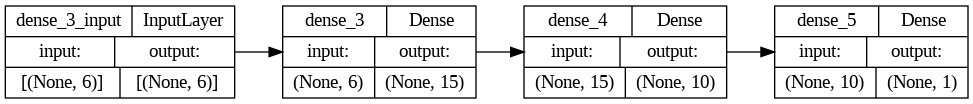

In [25]:
keras.utils.plot_model(ann_clf, show_shapes=True, rankdir="LR")

In [26]:
_, train_acc = ann_clf.evaluate(X_train, y_train, verbose=0)
_, val_acc = ann_clf.evaluate(X_val, y_val, verbose=0)
_, test_acc = ann_clf.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

Train: 0.860, Validation: 0.868, Test: 0.865


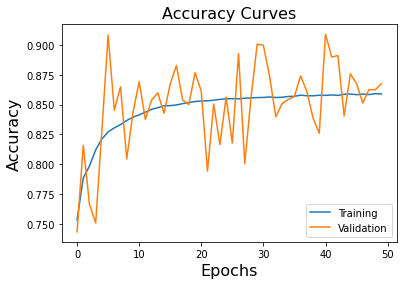

In [27]:
plt.plot(record.history['accuracy'], label='Training')
plt.plot(record.history['val_accuracy'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

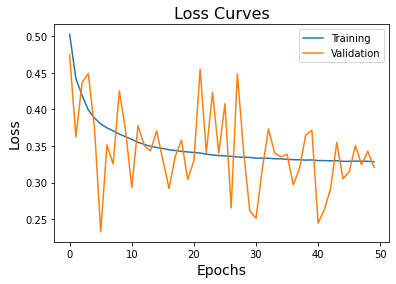

In [28]:
# plot training history
plt.plot(record.history['loss'], label='Training')
plt.plot(record.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Curves', fontsize=16)
plt.show()

#### Experiment 2: Different Batch Sizes

In [29]:
# Fit a Model and Plot Learning Curve

def fit_model_1(X_train, y_train, X_val, y_val, n_batch):
  
  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
      # keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam',
                  metrics=['accuracy'],
                  loss = 'binary_crossentropy')

  
  # Fit Model
  history = ann_clf.fit(X_train,
                      y_train,
                      validation_data=(X_val, y_val),
                      epochs=100,
                      verbose=0,
                      batch_size=n_batch)

  # Plot Learning Curves
  plt.plot(history.history['accuracy'], label='train') 
  plt.plot(history.history['val_accuracy'], label='test') 
  plt.title('batch='+str(n_batch)) 
  plt.legend()

In [ ]:
# Create Learning Curves for Different Batch Sizes

# batch_sizes = [4, 6, 10, 16, 32, 64, 128, 260]
batch_sizes = [5, 10, 15, 20, 25, 30]

plt.figure(figsize=(10,15))
for i in range(len(batch_sizes)):

  # Determine the Plot Number
  plot_no = 420 + (i+1)
  plt.subplot(plot_no)

  # Fit Model and Plot Learning Curves for a Batch Size
  fit_model_1(X_train, y_train, X_val, y_val, batch_sizes[i])

plt.show()

Based on the accuracy graph above, the model that is good enough to show stability is the model with batch size 15

#### Experiment 3: Different EPOCHs

In [ ]:
# Fit a Model and Plot Learning Curve

def fit_model_2(X_train, y_train, X_val, y_val, n_epoch):

  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
      # keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam',
                  metrics=['accuracy'],
                  loss = 'binary_crossentropy')

    
  # Fit Model
  history = ann_clf.fit(X_train,
                      y_train,
                      validation_data=(X_val, y_val),
                      epochs=n_epoch,
                      verbose=0,
                      batch_size=15)
    
  # Plot Learning Curves
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.title('epoch='+str(n_epoch))
  plt.legend()

In [ ]:
# Create Learning Curves for Different EPOCHs

epochs = [20, 50, 80, 100]

plt.figure(figsize=(10,15))
for i in range(len(epochs)):

  # Determine the Plot Number
  plot_no = 420 + (i+1)
  plt.subplot(plot_no)

  # Fit Model and Plot Learning Curves for an EPOCH
  fit_model_2(X_train, y_train, X_val, y_val, epochs[i])

plt.show()

Based on the accuracy graph above, the model that is good enough to show stability is the model with EPCOH 50

#### Experiment 4: Early Stopping

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
def fit_model_3():

  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
      # keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam',
                  metrics=['accuracy'],
                  loss = 'binary_crossentropy')

  return ann_clf

ann_clf = fit_model_3()

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=150)

mc = ModelCheckpoint('best_model.h5',
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)

history = ann_clf.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    verbose=0,
                    batch_size=15,
                    callbacks=[es, mc])

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Curves', fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)

plt.show()

In [ ]:
_, train_acc = ann_clf.evaluate(X_train, y_train, verbose=0)
_, val_acc = ann_clf.evaluate(X_val, y_val, verbose=0)
_, test_acc = ann_clf.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

Accuracy result for no early stopping  - Train: 0.964, Validation: 0.946, Test: 0.945

Accuracy result for early stopping - Train: 0.961, Validation: 0.935, Test: 0.931

Early stopping is not beneficial

## Voting Classifier

- Library: Scikit-learn, Keras, Tensorflow
- Shuffling does not affect the model building. No random_state.
- No need for RandomizedSearchCV since there is only 1 important hyperparameter: voting

In [ ]:
# Re-train top 3 models using their best hyperparameters

model_1 = LGBMClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=10)
model_2 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.5, max_depth=1, random_state=10)
model_3 = RandomForestClassifier(n_estimators=1000, max_depth = None, n_jobs =-1, random_state=10)

name = 'ensem_clf'

train = pd.DataFrame(columns = ['voting', 'n_jobs'])
train = train.append({'voting': 'hard', 'n_jobs': -1}, ignore_index=True)
train = train.append({'voting': 'soft', 'n_jobs': -1}, ignore_index=True)
train = train.reset_index()

for index, row in train.iterrows():
    model_name = name + str(index)
    ens_clf = VotingClassifier(estimators=[('m1', model_1), ('m2', model_2), ('m3', model_3)],
                               voting = row['voting'],
                               n_jobs = int(row['n_jobs']))
    ens_clf.fit(X_train, y_train)
    y_true = y_val
    y_pred = ens_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': ens_clf, 
                            'parameters': ens_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

Best Parameters: 

{'voting': 'hard'}

# Model Training & Validation Results

## Best hyperparameters for each model:

**log_clf:**

{'warm_start': True,
 'solver': 'lbfgs',
 'penalty': 'none',
 'max_iter': 331,
 'dual': False,
 'C': 0}

**svm_clf:**

{'kernel': 'rbf','C' : '8','class_weight'='balanced'}

**bayes_clf:**

{'var_smoothing': '1e-3'}

**knn_clf:**

{'n_neighbors': 19, 'algorithm': 'kd_tree'}

**tree_clf:**

{'splitter': 'random',
 'min_samples_leaf': 2,
 'max_features': 11,
 'max_depth': None,
 'criterion': 'entropy'}

**rnd_clf:**

{'n_estimators': 415,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 4,
 'max_depth': 18}

**gboost_clf:**

{'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.1}

**xgboost_clf:**

{'n_estimators': 1000,
 'min_child_weight': 7,
 'max_depth': 8,
 'learning_rate': 0.1}

**lightgbm_clf:**

{'num_leaves': 50,
 'n_estimators': 1000,
 'min_data_in_leaf': 10,
 'max_depth': 8,
 'learning_rate': 0.05}

**ann_clf:**
- Batch size 15
- EPOCH 50

**ens_clf:**

{'voting':'hard'}

